In [1]:
import mlflow
import os
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from pickle import dump

from hyperopt import fmin, tpe, Trials, STATUS_OK, hp, space_eval
from functools import partial

from scripts.preprocessing_regression_models import Preprocess
from scripts.config_regression import (year_month_train, 
    input_data_path_train,
    seed)

### MLFlow setting

In [ ]:
local_path_save = './local_artifacts_tmp/02_1_Ridge_Regression/'

In [2]:
if not os.path.exists(local_path_save):
    os.makedirs(local_path_save)

#save all metadata in a sqlite db. Artifacts will be saved on local folder ./mlflow    
mlflow.set_tracking_uri("sqlite:///mlflow.db")

# Name of the experiment
exp_name = "02.1 - Regularized Linear Regression - Ridge"
# set up MlFlow axperiment
experiment_id = mlflow.set_experiment(exp_name)

In [3]:
year_month = year_month_train
input_data_path = input_data_path_train

### Fitting and evaluation functions

In [4]:
def lr_evaluation(Y_train, Y_test, Y_pred_train, Y_pred_test):
        ''' 
        Function for evaluation of Linear Regression goodness
        '''
        rmse_train = mean_squared_error(Y_train,Y_pred_train)**0.5
        rmse_test = mean_squared_error(Y_test,Y_pred_test)**0.5
        
        mae_train = mean_absolute_error(Y_train, Y_pred_train)
        mae_test = mean_absolute_error(Y_test, Y_pred_test)
    
        return rmse_train, rmse_test, mae_train, mae_test

In [22]:
def objective_lr_ridge(params, X_train, X_test, Y_train, Y_test, run_name: str = 'Unnamed'):
    '''
    Fitting function for Linear Regression with 
    Ridge Regularization
    '''
    with mlflow.start_run(run_name=run_name):
        mlflow.set_tag('model_type','RidgeLinearRegression')
        mlflow.set_tag('year_month',year_month)
        mlflow.log_param('model_type','RidgeLinearRegression')
        mlflow.log_param('data',input_data_path)
        mlflow.log_params(params)

        lr = Ridge(**params)

        lr.fit(X_train, Y_train)

        Y_pred_train = lr.predict(X_train)
        Y_pred_test = lr.predict(X_test)
        rmse_train, rmse_test, mae_train, mae_test = lr_evaluation(
                Y_train, Y_test, Y_pred_train, Y_pred_test
        )

        mlflow.log_metrics({'rmse_train': rmse_train, 
                            'rmse_test': rmse_test,
                            'mae_train': mae_train,
                            'mae_test': mae_test})

        print('rmse_train = ', rmse_train, 
              '\n rmse_test', rmse_test,
              '\n mae_train', mae_train,
              '\n mae_test', mae_test)

        mlflow.log_artifact(local_path = local_path_save + run_name + '_ohe.pkl', artifact_path='preprocessing') 
        mlflow.sklearn.log_model(lr, artifact_path='model')
    
    return {'loss': rmse_test, 'status': STATUS_OK}
    

## Experiments

In [ ]:
run_name = 'base'

In [23]:
max_evals = 5

# Here we can decide which hyperparameters we want to tune
# For the Ridge regression, alpha tunes the amount of regularization
# Alpha = 0 means no regularization == Linear Regression
ridge_parameters_search = {
    'alpha': hp.lognormal('alpha', 0, 1),
    'random_state': seed
}

In [24]:
#### Data Preprocessing ####

prepr = Preprocess(input_data_path_train)
X, Y = prepr.read_dataframe(request_tgt=True)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

#preprocessing ohe
shapes_pre = (X_train.shape[0], X_test.shape[0])
X_train_ohe, ohe = prepr.preprocess(df=X_train, fit_ohe=True)
X_test_ohe, _ = prepr.preprocess(df=X_test, fit_ohe=False, ohe=ohe)
assert shapes_pre == (X_train.shape[0], X_test.shape[0])
dump(ohe, open(local_path_save + run_name + '_ohe.pkl', 'wb'))

df shape (3576, 20)


In [25]:
trials = Trials()

best_result = fmin(
    fn=partial(objective_lr_ridge, 
        X_train=X_train_ohe,
        X_test=X_test_ohe,
        Y_train=Y_train,
        Y_test=Y_test),
    space=ridge_parameters_search,
    algo=tpe.suggest,
    max_evals=max_evals,
    trials=trials,
    rstate=np.random.default_rng(seed)
)

best_result

parametri qui:                                                                                                         
{'alpha': 0.18664685239980144, 'random_state': 123}                                                                    
rmse_train =                                                                                                           
3.3417412100368336                                                                                                     
                                                                                                                       
 rmse_test
16078.420480351486                                                                                                     
                                                                                                                       
 mae_train
2.3264314700237856                                                                                                     
                  

/Users/davideposillipo/.pyenv/versions/3.10.9/envs/mlops/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



rmse_train =                                                                                                           
3.3437131896347987                                                                                                     
                                                                                                                       
 rmse_test
15969.703320644589                                                                                                     
                                                                                                                       
 mae_train
2.328351416322692                                                                                                      
                                                                                                                       
 mae_test
503.2205380027892                                                                                                      
parametr

{'alpha': 1.7708875603575491}

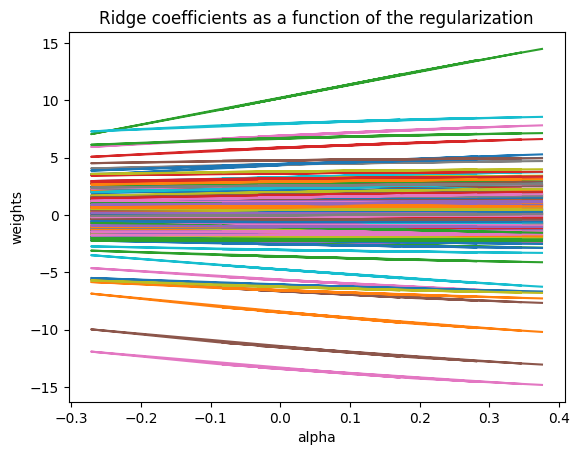

In [100]:
import matplotlib.pyplot as plt

n_alphas = 10
alphas = np.random.lognormal(0, 0.5, n_alphas)

coefs = []
for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_ohe, Y_train)
    coefs.append(ridge.coef_)
    
ax = plt.gca()

neg_log_alphas_ridge = -np.log10(alphas)

ax.plot(neg_log_alphas_ridge, coefs)
#ax.set_xlim(ax.get_xlim()[::-1])
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show()